# Simple Model of a Car on a Bumpy Road

This notebook allows you to compute and visualize the car model presented in Example 2.4.2 the book.

The road is described as:

$$y(t) = Ysin\omega_b t$$

And $\omega_b$ is a function of the car's speed.

In [1]:
import numpy as np

In [2]:
def x_h(t, wn, zeta, x0, xd0):
    """Returns the transient vertical deviation from the equilibrium of the mass.
    
    Parameters
    ==========
    t : ndarray, shape(n,)
        An array of monotonically increasing values for time.
    zeta : float
        The damping ratio of the system.
    x0 : float
        The initial displacement from the equilibrium.
    xd0 : float
        The initial velocity of the mass.
        
    Returns
    ========
    x_h : ndarray, shape(n,)
        An array containing the displacement from equilibrium as a function of time.
    
    """
    
    wd = wn * np.sqrt(1 - zeta**2)
    
    A = np.sqrt(x0**2 + ((xd0 + zeta * wn * x0) / wd)**2)
    
    phi = np.arctan2(x0 * wd, xd0 + zeta * wn * x0)
    
    return A * np.exp(-zeta * wn * t) * np.sin(wd * t + phi)

def x_p(t, wn, zeta, Y, wb):
    """Returns the steady state vertical deviation from the equilibrium of the mass.
    
    Parameters
    ==========
    t : ndarray, shape(n,)
        An array of monotonically increasing values for time.
    wn : float
        The natural frequency of the system in radians per second.
    zeta : float
        The damping ratio of the system.
    Y : float
        The amplitude of the road bumps in meters.
    wb : float
        The frequency of the road bumps in radians per second.
    

    Returns
    ========
    x_p : ndarray, shape(n,)
        An array containing the displacement from equilibrium as a function of time.
    
    """
    
    theta1 = np.arctan2(2 * zeta * wn * wb, (wn**2 - wb**2))
    
    theta2 = np.arctan2(wn, 2 * zeta * wb)
    
    amp = wn * Y * ((wn**2 + (2 * zeta * wb)**2) / ((wn**2 - wb**2)**2 + (2 * zeta * wn * wb)**2))**0.5
    
    return amp * np.cos(wb * t - theta1 - theta2)

def compute_force(t, m, c, k, Y, wb):
    """Returns the total force acting on the mass.
    
    Parameters
    ==========
    t : ndarray, shape(n,)
        An array of monotonically increasing values for time.
    m : float
        The mass of the vehicle in kilograms.
    c : float
        The damping coefficient in Newton seconds per meter.
    k : float
        The spring stiffness in Newtons per meter.
    Y : float
        The amplitude of the road bumps in meters.
    wb : float
        The frequency of the road bumps in radians per second.
 
        
    Returns
    ========
    f : ndarray, shape(n,)
        An array containing the acting on the mass as a function of time.
    
    """
    
    wn = np.sqrt(k / m)
    
    zeta = c / 2 / m / wn    
    
    r = wb / wn
    
    amp = k * Y * r**2 * np.sqrt((1 + (2 * zeta * r)**2) / ((1 - r**2)**2 + (2 * zeta * r)**2))
    
    theta1 = np.arctan2(2 * zeta * wn * wb, (wn**2 - wb**2))
    
    theta2 = np.arctan2(wn, 2 * zeta * wb)
    
    return -amp * np.cos(wb * t - theta1 - theta2) 

def compute_trajectory(t, m, c, k, Y, wb, x0, xd0):
    """Returns the combined transient and steady state deviation of the mass from equilibrium.
    
    Parameters
    ==========
    t : ndarray, shape(n,)
        An array of monotonically increasing values for time.
    m : float
        The mass of the vehicle in kilograms.
    c : float
        The damping coefficient in Newton seconds per meter.
    k : float
        The spring stiffness in Newtons per meter.
    Y : float
        The amplitude of the road bumps in meters.
    wb : float
        The frequency of the road bumps in radians per second.x0 : float
        The initial displacement.
    xd0 : float
        The initial velocity of the mass.
        
    Returns
    ========
    x_h : ndarray, shape(n,)
        An array containing the displacement from equilibrium as a function of time.
        
    
    """
    
    wn = np.sqrt(k / m)
    
    zeta = c / 2 / m / wn
    
    return x_h(t, wn, zeta, x0, xd0) + x_p(t, wn, zeta, Y, wb)

Now start with the parameters given in the book.

In [3]:
Y = 0.01  # m
v = 20  # km/h
m = 1007  # kg
k = 4e4  # N/m
c = 20e2  # Ns/m
x0 = -0.05  # m
xd0 = 0  # m/s
bump_distance = 6  # m

The bump frequency is a function of the distance between the bumps and the speed of the vehicle.

In [4]:
wb = v / bump_distance * 1000 / 3600 * 2 * np.pi  # rad /s

It is worth noting what the frequency ratio is:

In [5]:
r = np.sqrt(k / m) / wb
r

1.0833259528706427

Now pick some time values and compute the displacement and the force trajectories.

In [6]:
t = np.linspace(0, 20, num=500)

x = compute_trajectory(t, m, c, k, Y, wb, x0, xd0)

f = compute_force(t, m, c, k, Y, wb)

Plot the trajectories.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'F / k [m]')

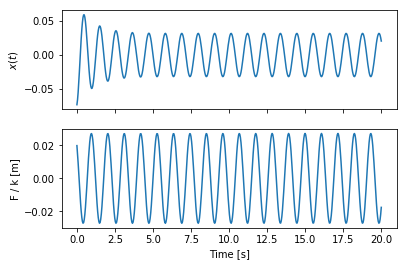

In [8]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(t, x)
axes[1].plot(t, f / k)
axes[1].set_xlabel('Time [s]')
axes[0].set_ylabel('$x(t)$')
axes[1].set_ylabel('F / k [m]')

Now animate the simulation of the model showing the motion and a vector that represents the force per stiffness value.

In [9]:
from matplotlib.patches import Rectangle
import matplotlib.animation as animation

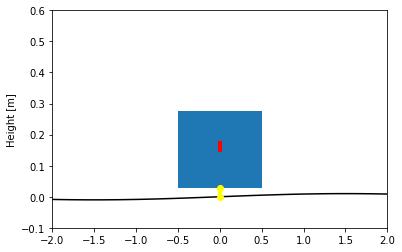

In [10]:
fig, ax = plt.subplots(1, 1)

ax.set_ylim((-0.1, 0.6))
ax.set_ylabel('Height [m]')
#ax.set_aspect('equal')

xeq = 0.1  # m
view_width = 4  # m
rect_width = 1.0  # m
rect_height = rect_width / 4  # m
bump_distance = 6 # m
lat_pos = 0

lat = np.linspace(lat_pos - view_width / 2, lat_pos + view_width / 2, num=100)

ax.set_xlim((lat[0], lat[-1]))

rect = Rectangle(
                 (-rect_width / 2, xeq + x0),  # (x,y)
                 rect_width,  # width
                 rect_height,  # height
                )

car = ax.add_patch(rect)

road = ax.plot(lat, Y * np.sin(2 * np.pi / bump_distance * lat), color='black')[0]

suspension = ax.plot([lat_pos, lat_pos],
                     [Y * np.sin(2 * np.pi / bump_distance * lat_pos), xeq + x0],
                     linewidth='4', marker='o', color='yellow')[0]
force_vec = ax.plot([lat_pos, lat_pos],
                    [xeq + x0 + rect_height / 2, xeq + x0 + rect_height / 2 + 0.2],
                    'r', linewidth=4)[0]

def kph2mps(speed):
    # km   1 hr     1 min    1000 m
    # -- * ------ * ------ * ------
    # hr   60 min   60 sec   1 km
    return speed * 1000 / 3600

def animate(i):
    # update the data for all the drawn elements in this function
    
    lat_pos = kph2mps(v) * t[i]
        
    ax.set_xlim((lat_pos - view_width / 2, lat_pos + view_width / 2))
    
    rect.set_xy([lat_pos - rect_width / 2, xeq + x[i]])
    
    road.set_xdata(lat + lat_pos)
    road.set_ydata(Y * np.sin(2 * np.pi / bump_distance * (lat + lat_pos)))
    
    suspension.set_xdata([lat_pos, lat_pos])
    suspension.set_ydata([Y * np.sin(2 * np.pi / bump_distance * lat_pos), xeq + x[i]])
    
    force_vec.set_xdata([lat_pos, lat_pos])
    force_vec.set_ydata([xeq + x[i] + rect_height / 2,
                         xeq + x[i] + rect_height / 2 + f[i] / k])

ani = animation.FuncAnimation(fig, animate, frames=len(t), interval=25)

# Questions


Explore the model and see if you can select a damping value that keeps the car pretty stable as it traverses the road.

What happens if you change the driving speed? Do the values of $k$ and $c$ work well for all speeds?

Can you detect the difference in displacement transmissibility and force transmissibility for different driving speeds?